<a href="https://colab.research.google.com/github/khelloufleila/VSB-Power-Line-Fault-Detection/blob/master/main_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [46]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [47]:
!pip install siml

In [48]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import pyarrow.parquet as pq #reading parquet files 
import matplotlib.pyplot as plt
import os
import seaborn as sns
import scipy
from statsmodels.robust import mad
import collections
from scipy.signal import *
import random
import gc



#used for plotting
import plotly.graph_objects as go
#used for feature engineering(signal processing tools)
from scipy.fftpack import fft
from scipy.signal import welch
from siml.sk_utils import *
from siml.signal_analysis_utils import *

from tqdm import tqdm
import ast

import warnings
warnings.filterwarnings('ignore')


In [ ]:
metadata_train = pd.read_csv('/content/drive/MyDrive/Projet Option Stage /metadata_train.csv')
metadata_train.head(6)

,signal_id,id_measurement,phase,target
0,0,0,0,0
1,1,0,1,0
2,2,0,2,0
3,3,1,0,1
4,4,1,1,1
5,5,1,2,1


In [ ]:
df1 = pq.read_pandas('/content/drive/MyDrive/Projet Option Stage /train.parquet', columns=[str(i) for i in range(3100)]).to_pandas()

In [ ]:
df2= pq.read_pandas('/content/drive/MyDrive/Projet Option Stage /train.parquet', columns=[str(i) for i in range(3100, 6000)]).to_pandas()

In [ ]:
df3= pq.read_pandas('/content/drive/MyDrive/Projet Option Stage /train.parquet', columns=[str(i) for i in range(6000, 8712)]).to_pandas() 

In [ ]:
data= pd.concat([df1,df2, df3], axis=1)
data.shape

(800000, 8712)

In [ ]:
data.to_csv('/content/drive/MyDrive/Projet Option Stage /'+"data.csv", sep=",")

In [ ]:
data.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,8672,8673,8674,8675,8676,8677,8678,8679,8680,8681,8682,8683,8684,8685,8686,8687,8688,8689,8690,8691,8692,8693,8694,8695,8696,8697,8698,8699,8700,8701,8702,8703,8704,8705,8706,8707,8708,8709,8710,8711
0,18,1,-19,-16,-5,19,-15,15,-1,-16,-9,23,-1,-17,16,-8,17,-10,21,-8,-12,-7,23,-15,-20,13,4,-20,1,15,13,-2,-17,5,16,-20,9,-16,7,10,...,19,17,-16,-5,1,19,-18,1,13,-19,6,12,-18,-8,18,-9,19,-7,-12,-1,-3,-3,-19,8,3,-12,18,-6,-11,-5,18,-22,12,8,13,6,-21,-15,-9,20
1,18,0,-19,-17,-6,19,-17,16,0,-15,-10,22,0,-16,17,-7,17,-10,20,-9,-12,-7,24,-14,-20,14,4,-20,1,15,14,-3,-18,5,16,-20,9,-15,7,9,...,19,23,-13,0,0,19,-19,0,13,-20,7,12,-17,-8,17,-9,19,-7,-12,0,-1,-2,-18,10,6,-10,18,-5,-12,-7,17,-21,12,8,14,7,-19,-15,-8,21
2,17,-1,-20,-17,-6,19,-17,15,-3,-15,-10,22,-1,-16,17,-9,16,-11,20,-8,-12,-6,24,-14,-20,13,4,-20,1,15,11,-3,-18,5,16,-20,8,-16,7,10,...,19,12,-18,-6,-1,19,-19,0,14,-20,5,12,-17,-8,17,-9,18,-10,-14,1,-1,-1,-17,11,4,-10,19,-5,-12,-9,16,-21,13,8,15,8,-18,-14,-8,22
3,18,1,-19,-16,-5,20,-16,16,0,-15,-9,22,-1,-17,17,-7,18,-9,21,-8,-12,-5,25,-14,-21,14,4,-20,1,15,14,-3,-17,5,16,-20,8,-16,7,10,...,19,21,-15,-3,0,19,-19,0,14,-18,4,11,-18,-9,16,-10,19,-9,-13,1,-1,-2,-19,8,3,-9,19,-4,-13,-9,16,-21,12,8,15,8,-19,-14,-7,23
4,18,0,-19,-16,-5,20,-17,16,-2,-14,-8,24,-2,-17,16,-9,16,-11,20,-8,-13,-6,24,-13,-21,14,4,-20,1,15,14,-3,-18,4,16,-21,8,-16,7,10,...,19,19,-14,-2,1,19,-18,2,14,-18,5,12,-18,-9,16,-10,19,-8,-13,-1,-2,-2,-18,9,5,-9,20,-4,-12,-8,17,-22,12,8,15,8,-18,-14,-8,23


# Feature Extraction Functions:
1. Statistical Features
3. Root Mean Square Energy
4. Zero-Crossing Rate
5. Entropy features
6. welch_max_power_and_frequency

In [ ]:
def describe_freq(signal):
    mean = np.mean(signal)
    std = np.std(signal) 
    maxv = np.amax(signal) 
    minv = np.amin(signal) 
    median = np.median(signal)
    skew = scipy.stats.skew(signal)
    kurt = scipy.stats.kurtosis(signal)
    q0 = np.quantile(signal, 0.10)
    q1 = np.quantile(signal, 0.25)
    q3 = np.quantile(signal, 0.75)
    q4 = np.quantile(signal, 0.90)
    mode = scipy.stats.mode(signal)[0][0]
    iqr = scipy.stats.iqr(signal) 
    rmse= np.sqrt(np.mean(signal**2))
    
    return [mean, std, maxv, minv, median, skew, kurt, q0, q1, q3,q4, mode, iqr, rmse]

In [ ]:
def describe_entropy(signal):
    counter_values= collections.Counter(signal).most_common()
    proba= [el[1]/len(signal) for el in counter_values]
    entropy=scipy.stats.entropy(proba)
    return entropy 

In [ ]:
def describe_crossings(signal):
    zero_crossing_index= np.nonzero(np.diff(np.array(signal)> 0))[0]
    len_zero_crossing= len(zero_crossing_index)
    mean_crossing_index= np.nonzero(np.diff(np.array(signal)> np.nanmean(signal)))[0]
    len_mean_crossing= len(mean_crossing_index)
    return [len_zero_crossing, len_mean_crossing ]

[texte du lien](https://)**Power Spectral density**

similiar to fft but this also considers the power distribution at each frequency.

Welch’s method computes an estimate of the power spectral density by dividing the data into overlapping segments, computing a modified periodogram for each segment and averaging the periodograms.

In [ ]:
def welch_max_power_and_frequency(signal):
    f, Pxx = welch(signal)
    ix = np.argmax(Pxx)
    strong_count = np.sum(Pxx>2.5)
    avg_amp = np.mean(Pxx)
    sum_amp = np.sum(Pxx)
    std_amp = np.std(Pxx)
    median_amp = np.median(Pxx)
    return [Pxx[ix], f[ix], strong_count, avg_amp, sum_amp, std_amp, median_amp]

In [ ]:
fourier_values = fft(data['0'].values)
fourier_values.shape

(800000,)

In [ ]:
def extract_fourier_features(signal,N=800000,T=1/50):
    '''
    converts a signal from time spectrum to frequency spectrum
    and returns only the features required as mentioned above
    '''
    fourier_values = fft(signal)
    fourier_values_filtered = 2.0/N * np.abs(fourier_values[0:N//2])
    return fourier_values_filtered


def filter_features_fourier(features,mph,no_features=8):
    '''
    returns fourier transformed features by extracting peaks and 
    considering only required number of peaks.
    mph-detect peaks that are greater than minimum peak height
    '''
    indices_peaks = detect_peaks(features,mph = mph)
    #print(indices_peaks)
    values = features[indices_peaks]
    if len(values)< no_features:
        return np.append(values , [0]*(no_features-len(values)))
    else:
        return values[:no_features]

In [ ]:
def get_features(signal):
    entropy = describe_entropy(signal)
    statistics = describe_freq(signal)
    crossings = describe_crossings(signal)
    powerfreq= welch_max_power_and_frequency(signal)
    return [entropy] + statistics + crossings + powerfreq

In [ ]:
total_features = []
   
for i in tqdm(range(0,8712)):
    fourier_features = np.empty((3,8))
    features = []    
    signal =  pq.read_pandas('/content/drive/MyDrive/Projet Option Stage /train.parquet',columns=[str(i)]).to_pandas()[str(i)].values

    #minimum peak height which can be used to filter fourier features
    mph = signal.min() + (signal.max() - np.abs(signal.min()))/10
    
    #fourier features
    fourier_features_ = extract_fourier_features(signal)
    fourier_features = filter_features_fourier(fourier_features_,mph)
    
    features.extend(fourier_features)

    total_features.append(features) 

In [ ]:
sig_features = np.array(total_features)

cols=[]
for i in range(0,8):
  cols.append('feat'+str(i))
fourier_df = pd.DataFrame(sig_features, columns =cols)  
fourier_df.to_csv('/content/drive/MyDrive/Projet Option Stage /'+"fourier_feat.csv", sep=",")

In [ ]:

feature_columns= [ 'signal_id', 'entropy', 'mean', 'std', 'maxv', 'minv', 'median', 'skew', 'kurt', 
                         'q0','q1', 'q3','q4', 'mode', 'iqr', 'rmse', 'len_zero_crossing', 'len_mean_crossing',
                       'max_amp', 'max_freq', 'strong_amp_count', 'avg_amp', 'sum_amp', 'std_amp', 'median_amp', 'fault']

data_type = "data"
df_feature_matrix= pd.DataFrame([], columns= feature_columns)
for signal_id in metadata_train.signal_id:
    signal_0 = data[str(signal_id)]
    signal_features= get_features(signal_0)
    df_features = pd.DataFrame([[signal_id] + signal_features + [metadata_train.target[metadata_train.signal_id == signal_id].values[0]]], columns=feature_columns)

    df_feature_matrix = df_feature_matrix.append(df_features, ignore_index=True)  # Append Feature Matrix Data Frame

# Store feature matrix to CSV (commented out for this notebook, but left in for example.)
df_feature_matrix.to_csv('/content/drive/MyDrive/Projet Option Stage/'+data_type+"_get_features.csv", sep=",")

In [49]:
df_feature= pd.read_csv('/content/drive/MyDrive/Projet Option Stage /data_get_features.csv')
fourier_df=pd.read_csv('/content/drive/MyDrive/Projet Option Stage /fourier_feat.csv')
features= [ 'entropy', 'mean', 'std', 'maxv', 'minv', 'median', 'skew', 'kurt', 
                         'q0','q1', 'q3', 'q4','mode', 'iqr', 'rmse', 'len_zero_crossing', 'len_mean_crossing',
                       'max_amp', 'max_freq', 'strong_amp_count', 'avg_amp', 'sum_amp', 'std_amp', 'median_amp']
fourier_cols= ['feat0','feat1','feat2','feat3','feat4','feat5','feat6','feat7']                       

target= ["fault"]
df= df_feature[features]
fouri_df= fourier_df[fourier_cols]
data_features= pd.concat([df,fouri_df], axis=1)
data_features["fault"]= df_feature[target]
data_features

,entropy,mean,std,maxv,minv,median,skew,kurt,q0,q1,q3,q4,mode,iqr,rmse,len_zero_crossing,len_mean_crossing,max_amp,max_freq,strong_amp_count,avg_amp,sum_amp,std_amp,median_amp,feat0,feat1,feat2,feat3,feat4,feat5,feat6,feat7,fault
0,3.691887,-0.960271,13.870724,33,-39,-1.0,0.003591,-1.433378,-20.0,-13.0,11.0,18.0,18,24.0,4.742362,7268,7468,47.831062,0.378906,18,1.995473,257.415955,5.220994,0.612473,19.406276,0.225003,2.402200,0.272933,0.141869,0.045181,0.086006,0.106678,0
1,3.663108,-0.194125,13.037134,26,-30,0.0,0.006952,-1.422562,-18.0,-12.0,12.0,17.0,-17,24.0,4.956490,8817,7990,41.982578,0.378906,20,1.836459,236.903198,4.641738,0.458779,18.240737,0.349034,2.209746,0.284463,0.093602,0.032817,0.067562,0.116957,0
2,3.686704,-0.043555,13.684282,39,-28,0.0,0.005427,-1.426438,-18.0,-13.0,12.0,18.0,-18,25.0,4.979899,7316,7048,38.999954,0.378906,22,1.935738,249.710236,4.503104,0.652928,19.162070,0.369614,2.196515,0.288878,0.122011,0.046373,0.106883,0.138665,0
3,3.645577,-0.997401,13.673630,52,-77,-1.0,-0.001616,-1.474346,-19.0,-14.0,12.0,17.0,-19,26.0,4.075930,5718,5840,29.060942,0.148438,16,1.590296,205.148132,3.224866,0.798159,19.240971,0.149745,1.387577,0.250357,0.129503,0.061754,0.030128,0.018160,1
4,3.604326,-0.175586,12.938372,33,-40,0.0,-0.000686,-1.478338,-17.0,-13.0,12.0,17.0,-17,25.0,4.931368,4210,4204,20.080660,0.148438,19,1.375932,177.495178,2.577763,0.439266,18.201435,0.099886,0.131096,1.397082,0.185577,0.095271,0.027941,0.058787,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8707,3.680224,-1.465155,12.994770,34,-34,-1.0,-0.002431,-1.456477,-19.0,-13.0,11.0,16.0,16,24.0,3.927279,4304,3226,49.766651,0.003906,19,3.020191,389.604675,8.131933,0.479636,18.234295,0.063686,0.472018,1.126217,0.604003,0.318325,0.068544,0.050267,0
8708,3.738676,-1.473611,13.855336,25,-28,-2.0,0.001417,-1.463561,-20.0,-14.0,11.0,17.0,18,25.0,3.615759,4468,3470,43.401005,0.074219,16,2.308487,297.794769,6.516478,0.348157,19.461875,0.067596,0.796427,1.257471,0.576875,0.300968,0.077492,0.050795,0
8709,3.743259,-1.003486,14.693115,37,-79,0.0,-0.014534,-1.433985,-21.0,-15.0,14.0,18.0,18,29.0,2.933922,6942,3876,18.879847,0.031250,12,1.333504,172.021988,2.445804,0.660026,20.646691,1.112545,0.773247,0.632877,0.346927,0.070884,0.182495,0.118627,0
8710,3.767086,-0.170313,14.107939,52,-76,-1.0,0.014371,-1.405970,-19.0,-13.0,14.0,19.0,19,27.0,2.692016,3168,3754,17.287521,0.031250,15,1.298961,167.565918,2.294397,0.493571,19.745831,1.534309,1.091698,0.776683,0.266818,0.160236,0.241421,0.193238,0


In [ ]:
data_features.shape

(8712, 33)

In [ ]:
fault= len(data_features[data_features.fault==1])
fault

525

# Machine Learning 

In [ ]:
import numpy as np
import pandas as pd
import warnings

## Plotting libraries
import seaborn as sns
import matplotlib.pyplot as plt

## Sklearn Libraries
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import f1_score, confusion_matrix, roc_curve, auc, classification_report, recall_score, precision_recall_curve
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb
import lightgbm as lgb
from sklearn.linear_model import SGDRegressor
from prettytable import PrettyTable



random_state = 1

class Create_ensemble(object):
    def __init__(self, n_splits, base_models):
        self.n_splits = n_splits
        self.base_models = base_models

    def predict(self, X, y, T):
        X = np.array(X)
        y = np.array(y)
        T = np.array(T)
        no_class = len(np.unique(y))

        folds = list(StratifiedKFold(n_splits=self.n_splits, shuffle=True, 
                                     random_state = random_state).split(X, y))

        train_proba = np.zeros((X.shape[0], no_class))
        test_proba = np.zeros((T.shape[0], no_class))
        
        train_pred = np.zeros((X.shape[0], len(self.base_models)))
        test_pred = np.zeros((T.shape[0], len(self.base_models)* self.n_splits))
        f1_scores = np.zeros((len(self.base_models), self.n_splits))
        recall_scores = np.zeros((len(self.base_models), self.n_splits))
        
        test_col = 0
        for i, clf in enumerate(self.base_models):
            
            for j, (train_idx, valid_idx) in enumerate(folds):
                
                X_train = X[train_idx]
                Y_train = y[train_idx]
                X_valid = X[valid_idx]
                Y_valid = y[valid_idx]
                
                clf.fit(X_train, Y_train)
                
                valid_pred = clf.predict(X_valid)
                recall  = recall_score(Y_valid, valid_pred, average='macro')
                f1 = f1_score(Y_valid, valid_pred, average='macro')
                mcc = matthews_corrcoef(Y_valid, valid_pred)
                
                recall_scores[i][j] = recall
                f1_scores[i][j] = f1
                
                train_pred[valid_idx, i] = valid_pred
                test_pred[:, test_col] = clf.predict(T)
                test_col += 1
                
                ## Probabilities
                valid_proba = clf.predict_proba(X_valid)
                train_proba[valid_idx, :] = valid_proba
                test_proba  += clf.predict_proba(T)
                
                print( "Model- {} and CV- {} recall: {}, f1_score: {}, mcc: {}".format(i, j, recall, f1, mcc))
                
            test_proba /= self.n_splits
            
        return train_proba, test_proba, train_pred, test_pred, clf

In [ ]:

model = lgb.LGBMClassifier(boosting_type='gbdt', objective='binary', num_leaves=50,
                                learning_rate=0.1, n_estimators=500, max_depth=6,
                                bagging_fraction=0.9, feature_fraction=0.9, reg_lambda=0.2)

base_models = [model]
n_splits = 5
lgb_stack = Create_ensemble(n_splits = n_splits, base_models = base_models)        

In [ ]:
data_features.fillna(999, inplace=True)

X = data_features.drop(['fault'], axis=1)
Y = data_features['fault'].values
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size= 0.33, random_state=42)
x_train.shape

(5837, 32)

In [ ]:
train_proba, test_proba, train_pred, test_pred, clf = lgb_stack.predict(x_train, y_train, x_test)

Model- 0 and CV- 0 recall: 0.7522583112447416, f1_score: 0.8188031177804891, mcc: 0.6704522478565199
Model- 0 and CV- 1 recall: 0.7880352362490275, f1_score: 0.8465598987257115, mcc: 0.713328396559863
Model- 0 and CV- 2 recall: 0.7762270513300862, f1_score: 0.8279536045710096, mcc: 0.6721200024778281
Model- 0 and CV- 3 recall: 0.7812425754335947, f1_score: 0.8439289491921069, mcc: 0.7122555974282241
Model- 0 and CV- 4 recall: 0.7481587075314802, f1_score: 0.7913544354964087, mcc: 0.595425307133759


In [ ]:
print('\nPerformance Metrics for LGBMClassifier Cross Validation')
print('1. The F-1 score of the model {}\n'.format(f1_score(y_train, train_pred, average='macro')))
print('2. The recall score of the model {}\n'.format(recall_score(y_train, train_pred, average='macro')))
print('3. The Matthews Correlation Coefficient: {}\n'.format(matthews_corrcoef(y_train, train_pred)))
print('4. Classification report \n {} \n'.format(classification_report(y_train, train_pred)))
print('5. Confusion matrix \n {} \n'.format(confusion_matrix(y_train, train_pred)))


Performance Metrics for LGBMClassifier Cross Validation
1. The F-1 score of the model 0.8255607470629065

2. The recall score of the model 0.7691626022972154

3. The Matthews Correlation Coefficient: 0.6715758442326459

4. Classification report 
               precision    recall  f1-score   support

           0       0.97      0.99      0.98      5493
           1       0.87      0.54      0.67       344

    accuracy                           0.97      5837
   macro avg       0.92      0.77      0.83      5837
weighted avg       0.97      0.97      0.96      5837
 

5. Confusion matrix 
 [[5464   29]
 [ 157  187]] 



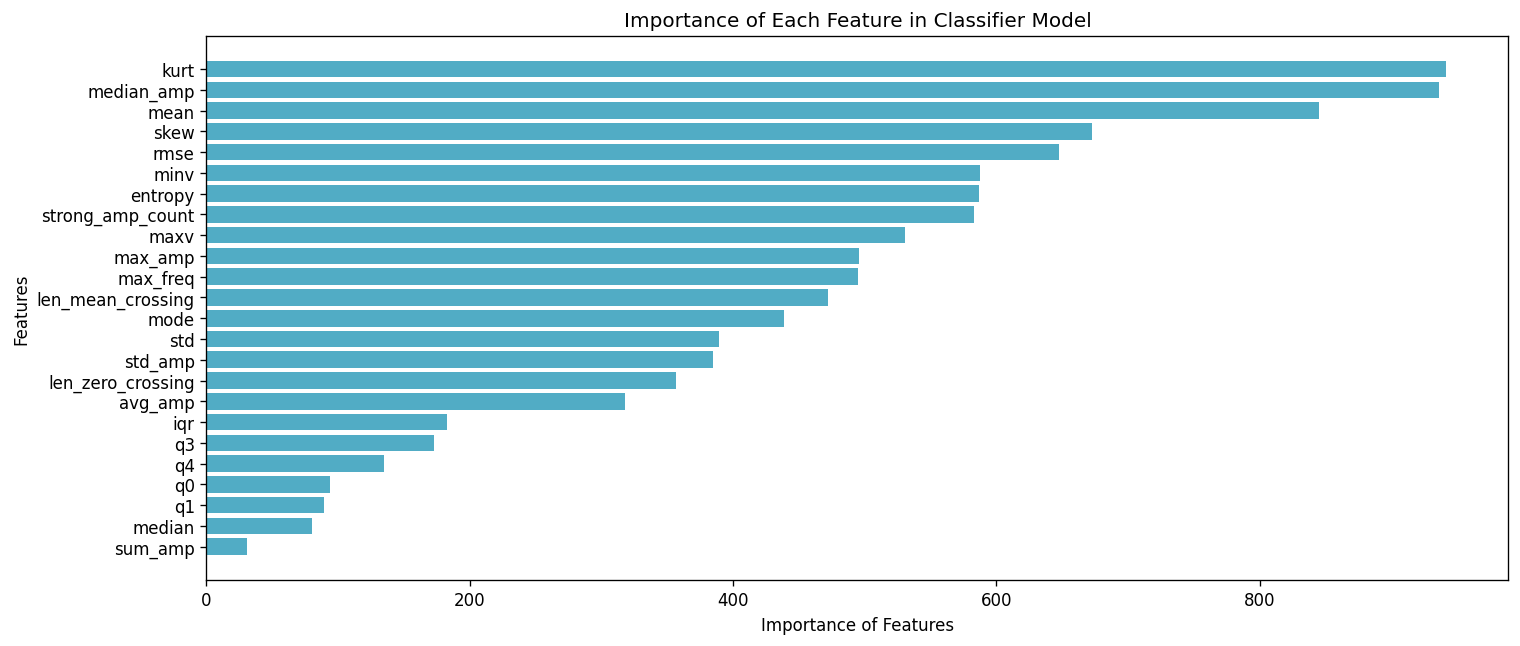

In [ ]:
# histogram of important features
imp = clf.feature_importances_
imp, features = zip(*sorted(zip(imp, features)))
blues = ["#66D7EB", "#51ACC5", "#3E849E", "#2C5F78", "#1C3D52", "#0E1E2B"]
f, ax = plt.subplots(figsize=(14, 6), dpi= 120, facecolor='w', edgecolor='k')
plt.barh(range(len(features)), imp, color=blues[1], align="center")
plt.yticks(range(len(features)), features)
plt.xlabel("Importance of Features")
plt.ylabel("Features")
plt.title("Importance of Each Feature in Classifier Model")
plt.show()

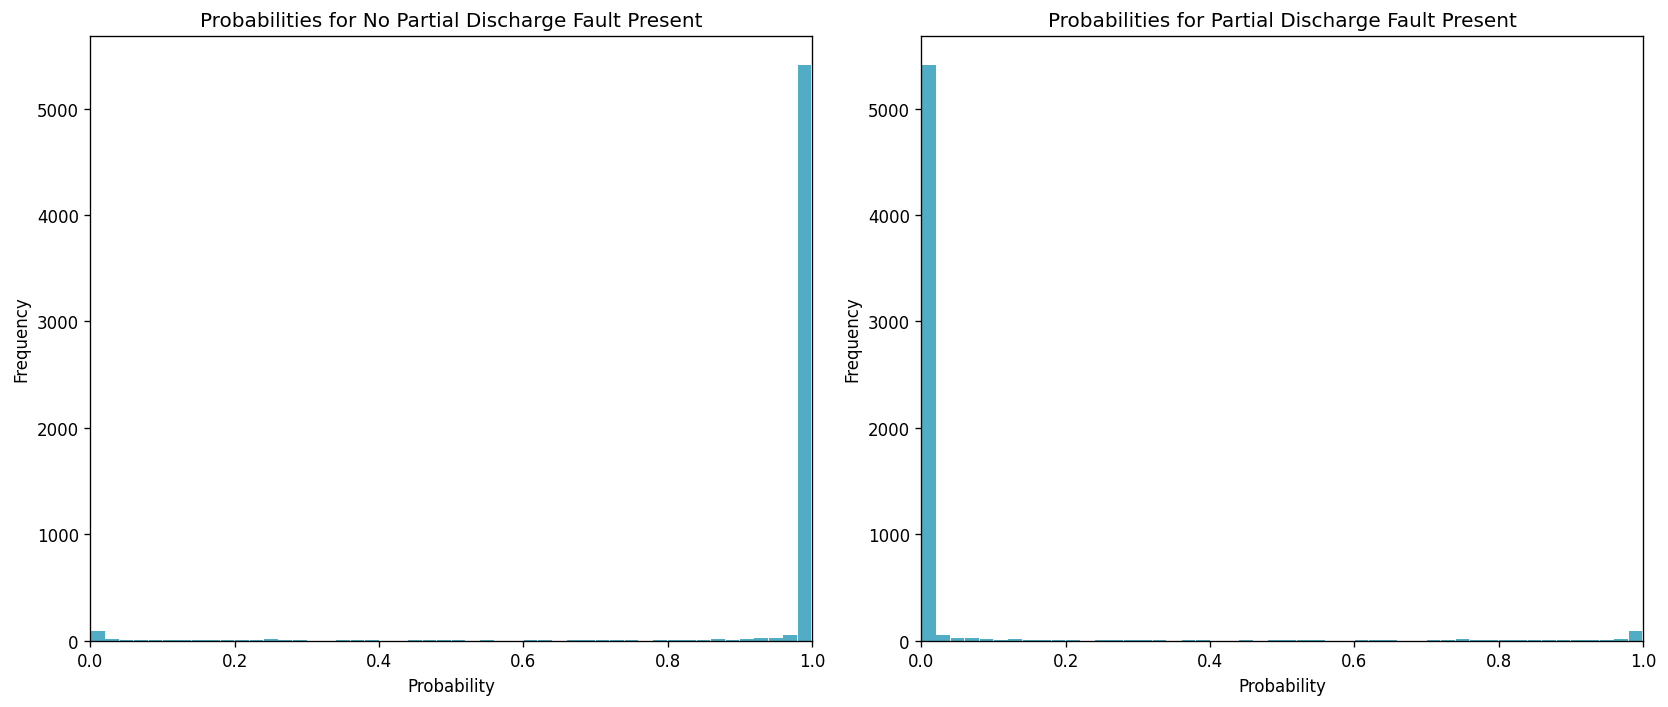

In [ ]:
# histogram of predicted probabilities
blues = ["#66D7EB", "#51ACC5", "#3E849E", "#2C5F78", "#1C3D52", "#0E1E2B"]
f, ax = plt.subplots(figsize=(14, 6), dpi= 120, facecolor='w', edgecolor='k')
nclasses = 2
titles = ["Probabilities for No Partial Discharge Fault Present", "Probabilities for Partial Discharge Fault Present"]
for i in range(nclasses):
    plt.subplot(1, nclasses, i+1)
    plt.hist(train_proba[:, i], bins=50, histtype='bar', rwidth=0.95, color=blues[1])
    plt.xlim(0,1)
    plt.title(titles[i])
    plt.xlabel('Probability')
    plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

In [ ]:
test_pred= np.median(test_pred, axis=1).astype(int)
test_pred.shape

(2875,)

In [ ]:
print('\nPerformance Metrics for LGBMClassifier Cross Validation')
print('1. The F-1 score of the model {}\n'.format(f1_score(y_test, test_pred, average='macro')))
print('2. The recall score of the model {}\n'.format(recall_score(y_test, test_pred, average='macro')))
print('3. The Matthews Correlation Coefficient: {}\n'.format(matthews_corrcoef(y_test, test_pred)))
print('4. Classification report \n {} \n'.format(classification_report(y_test, test_pred)))
print('5. Confusion matrix \n {} \n'.format(confusion_matrix(y_test, test_pred)))


Performance Metrics for LGBMClassifier Cross Validation
1. The F-1 score of the model 0.8071398920713989

2. The recall score of the model 0.7390323083422543

3. The Matthews Correlation Coefficient: 0.6529204376418938

4. Classification report 
               precision    recall  f1-score   support

           0       0.97      1.00      0.98      2694
           1       0.93      0.48      0.63       181

    accuracy                           0.96      2875
   macro avg       0.95      0.74      0.81      2875
weighted avg       0.96      0.96      0.96      2875
 

5. Confusion matrix 
 [[2687    7]
 [  94   87]] 



In [ ]:
df_test = pd.DataFrame() 
test_pred = np.median(test_pred).astype(int)
df_test['y_test'] =y_test.astype(int)
df_test["y_pred"] = test_pred
df_test

,y_test,y_pred
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
...,...,...
2870,0,0
2871,0,0
2872,0,0
2873,0,0


In [ ]:
# Make Submission File
submission_filename = "/content/drive/MyDrive/Projet Option Stage /prediction_submission_cv.csv"

# Commented out in this notebook but left in as an example to create a submission file
f_o = open(submission_filename, "w+")
f_o.write("signal_id,y_test,y_pred\n")
for idx in range(len(df_test)):

    signal_id = df_feature["signal_id"][idx]
    y_test= df_test["y_test"][idx]
    fault = df_test["y_pred"][idx]
    f_o.write(str(signal_id)+","+ str(y_test)+","+str(fault)+"\n")
f_o.close()

In [ ]:
df_test=pd.read_csv('/content/drive/MyDrive/Projet Option Stage /prediction_submission_cv.csv')
df_test

,signal_id,y_test,y_pred
0,0,0,0
1,1,0,0
2,2,0,0
3,3,0,0
4,4,0,0
...,...,...,...
2870,2870,0,0
2871,2871,0,0
2872,2872,0,0
2873,2873,0,0


PCA:

In [55]:
data_features.fillna(999, inplace=True)
Y= data_features['fault']
x= data_features.drop(['fault'], axis = 1)

In [56]:
from sklearn.preprocessing import StandardScaler
x = StandardScaler().fit_transform(x) # normalizing the features

In [57]:
feat_cols = ['feature'+str(i) for i in range(x.shape[1])]
normalised_dataset = pd.DataFrame(x,columns=feat_cols)
normalised_dataset.tail()

,feature0,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8,feature9,feature10,feature11,feature12,feature13,feature14,feature15,feature16,feature17,feature18,feature19,feature20,feature21,feature22,feature23,feature24,feature25,feature26,feature27,feature28,feature29,feature30,feature31
8707,-0.636022,-0.919241,-1.163737,-0.696721,0.742441,-0.451515,-0.287073,-0.223231,0.424598,0.897514,-1.275029,-1.275555,0.900733,-1.364148,-0.100244,-0.463152,-0.404985,-0.369584,-0.966972,-0.330320,-0.346919,-0.346919,-0.352007,-0.246229,-1.120462,-0.611252,-0.805582,0.821751,2.262919,0.293676,-0.737072,-0.632941
8708,-0.269638,-0.928739,-0.481481,-0.920736,0.892898,-1.482873,0.030103,-0.234832,-0.101515,0.236625,-1.275029,-0.771329,1.008648,-0.964230,-0.103180,-0.451563,-0.391803,-0.394223,-0.528886,-0.440697,-0.425473,-0.425473,-0.411689,-0.270844,-0.428231,-0.601811,-0.124922,1.056907,2.104526,0.186690,-0.658181,-0.625600
8709,-0.240911,-0.400687,0.182708,-0.622049,-0.385991,0.579843,-1.284605,-0.186399,-0.627627,-0.424264,0.588113,-0.267103,1.008648,0.635441,-0.109607,-0.276729,-0.369868,-0.489136,-0.796605,-0.587866,-0.533086,-0.533086,-0.562076,-0.212457,0.239886,1.921808,-0.173559,-0.062115,0.761924,-1.231513,0.267498,0.317581
8710,-0.091553,0.535148,-0.281218,-0.248691,-0.310762,-0.451515,1.097814,-0.140522,0.424598,0.897514,0.588113,0.237123,1.062605,-0.164395,-0.111888,-0.543432,-0.376460,-0.495300,-0.796605,-0.477489,-0.536899,-0.536899,-0.567670,-0.243620,-0.268108,2.940395,0.494601,0.195526,0.294193,-0.680763,0.786978,1.355019
8711,-0.306232,0.687543,0.239786,1.618099,-1.037973,1.611201,1.460708,-0.166770,-0.101515,-0.424264,1.209161,0.741349,-1.041733,1.035359,-0.124786,-0.264008,-0.299311,-0.483530,-0.796605,-0.293528,-0.488719,-0.488719,-0.543179,-0.177346,0.250147,3.352668,0.661437,0.192418,0.770070,0.057006,0.585661,-0.195633


In [59]:
from sklearn.decomposition import PCA
#pca = PCA(n_components=2)
pca= PCA()
principalComponents = pca.fit_transform(x)

In [61]:
#Store as dataframe and print 
df_pca= pd.DataFrame(principalComponents)
df_pca.round(2).head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31
0,2.24,0.39,-0.83,1.55,0.18,1.36,-1.02,0.49,0.55,-0.36,1.75,0.05,-2.41,0.10,-0.15,-0.02,1.25,0.09,0.59,0.30,-0.27,1.03,0.07,0.10,0.09,-0.01,-0.08,0.04,-0.02,0.01,0.0,0.0
1,3.31,0.69,0.83,1.76,0.27,1.73,-0.03,-0.52,0.22,-0.42,1.34,1.05,-1.95,-0.07,-0.34,0.17,0.99,0.48,0.38,-0.10,-0.20,0.20,0.01,0.10,0.06,-0.35,-0.09,0.09,-0.02,0.01,0.0,0.0
2,2.43,0.22,0.84,1.78,0.24,1.92,-0.09,-0.50,0.02,-0.34,1.43,0.99,-1.57,-0.04,-0.33,0.14,1.08,0.29,0.44,0.07,0.09,0.21,-0.07,-0.19,0.07,0.19,0.14,0.12,-0.01,0.01,-0.0,-0.0
3,1.95,0.04,-0.76,0.84,-0.76,-0.22,-0.18,-0.81,1.04,-0.26,0.14,1.58,-1.05,0.12,0.01,-0.20,0.84,0.29,-0.14,0.07,-0.11,-0.09,-0.06,0.44,0.02,0.04,0.12,0.00,-0.01,-0.00,-0.0,0.0
4,3.25,0.08,0.83,-0.33,-0.57,-1.78,1.15,-0.83,-0.70,-0.28,-0.29,0.56,-0.42,-1.17,-0.11,0.13,0.15,0.39,-0.03,-0.26,0.19,-0.30,-0.13,0.10,0.01,0.24,0.04,0.03,-0.01,-0.00,0.0,0.0


In [63]:
# Weights of Principal Componenets: (Eignevectors)
df_pca_loadings= pd.DataFrame(pca.components_)
df_pca_loadings.head()


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31
0,-0.303758,0.001719,-0.336785,-0.152713,0.151454,0.015209,-0.011761,-0.096845,0.292013,0.259282,-0.241705,-0.273752,-0.018928,-0.312541,-0.011388,-0.011257,0.056996,-0.129730,-0.058701,-0.224729,-0.234993,-0.234993,-0.159038,-0.180121,-0.319535,-0.008467,0.040271,0.047332,-0.028500,-0.046064,-0.011991,0.053088
1,-0.107696,-0.069174,-0.147885,0.163895,-0.163250,-0.063162,0.040671,0.249418,0.123910,0.119899,-0.189888,-0.181097,0.002104,-0.194830,-0.044747,0.331803,0.322740,0.222246,0.196697,0.224881,0.301394,0.301394,0.246995,0.235141,-0.196340,0.017419,0.013318,0.011619,-0.009611,-0.094442,-0.051679,-0.010101
2,-0.045670,0.553806,-0.006319,0.069939,-0.059041,0.537057,-0.004195,0.027072,0.267670,0.331657,0.307308,0.256172,-0.025731,-0.002805,0.085982,0.051208,0.059561,-0.010964,0.076022,0.052114,0.011196,0.011196,-0.020797,0.067754,-0.010507,-0.040528,-0.037623,0.020020,-0.106489,0.019447,0.089535,-0.021999
3,0.006087,0.080042,0.010971,0.043303,-0.037069,0.059177,0.025589,-0.021373,0.027780,0.023389,0.068064,0.050784,-0.003016,0.029675,-0.008303,0.003378,-0.006534,-0.013196,0.054869,-0.023420,-0.039242,-0.039242,-0.018487,-0.038357,0.014962,0.420486,0.237174,-0.378683,0.422637,-0.444557,-0.403432,0.227395
4,0.107248,0.044395,0.046849,-0.410744,0.414627,0.041165,-0.048162,-0.148560,-0.021495,-0.014675,0.067877,0.062195,0.008862,0.052589,-0.000366,0.263881,0.206527,0.434507,0.088563,-0.286895,0.005630,0.005630,0.391080,-0.214567,0.045338,0.037509,0.053352,-0.058736,0.000086,0.061464,0.041259,0.010221


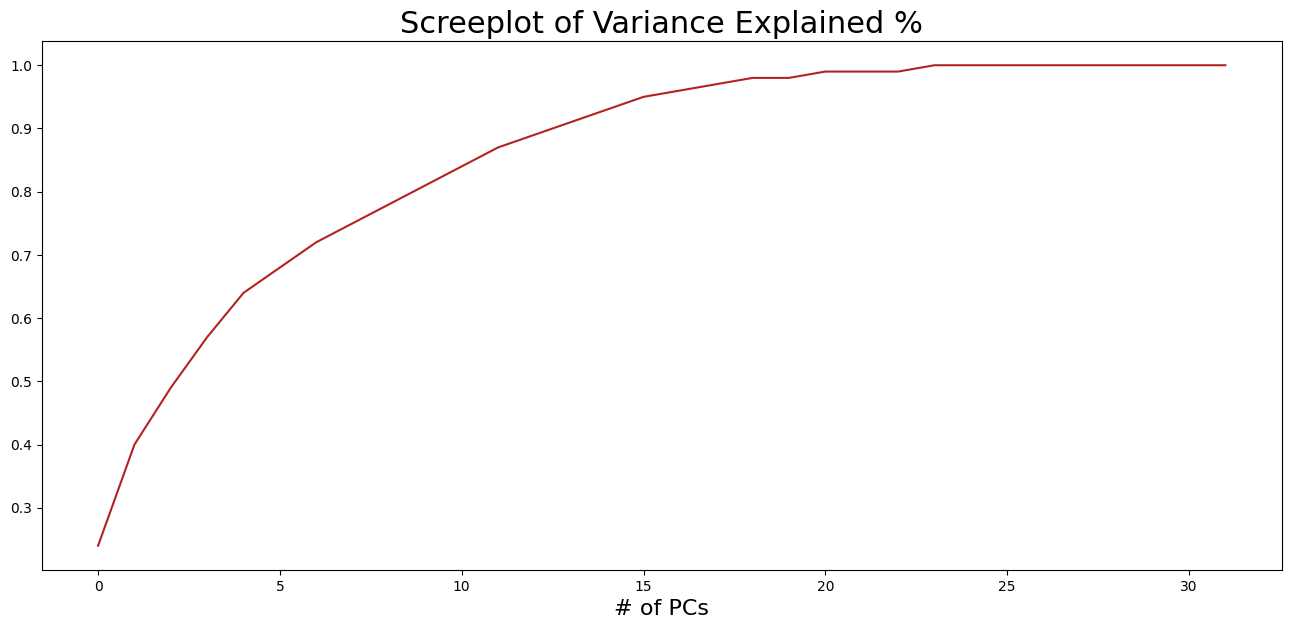

In [64]:
variance_exp_cumsum = pca.explained_variance_ratio_.cumsum().round(2)
fig, axes = plt.subplots(1,1,figsize=(16,7), dpi=100)
plt.plot(variance_exp_cumsum, color='firebrick')
plt.title('Screeplot of Variance Explained %', fontsize=22)
plt.xlabel('# of PCs', fontsize=16)
plt.show()

In [65]:
# Plot the clustering tendency 
from scipy.spatial import ConvexHull

def encircle(x,y, ax=None, **kw):
    if not ax: ax=plt.gca()
    p = np.c_[x,y]
    hull = ConvexHull(p)
    poly = plt.Polygon(p[hull.vertices,:], **kw)
    ax.add_patch(poly)

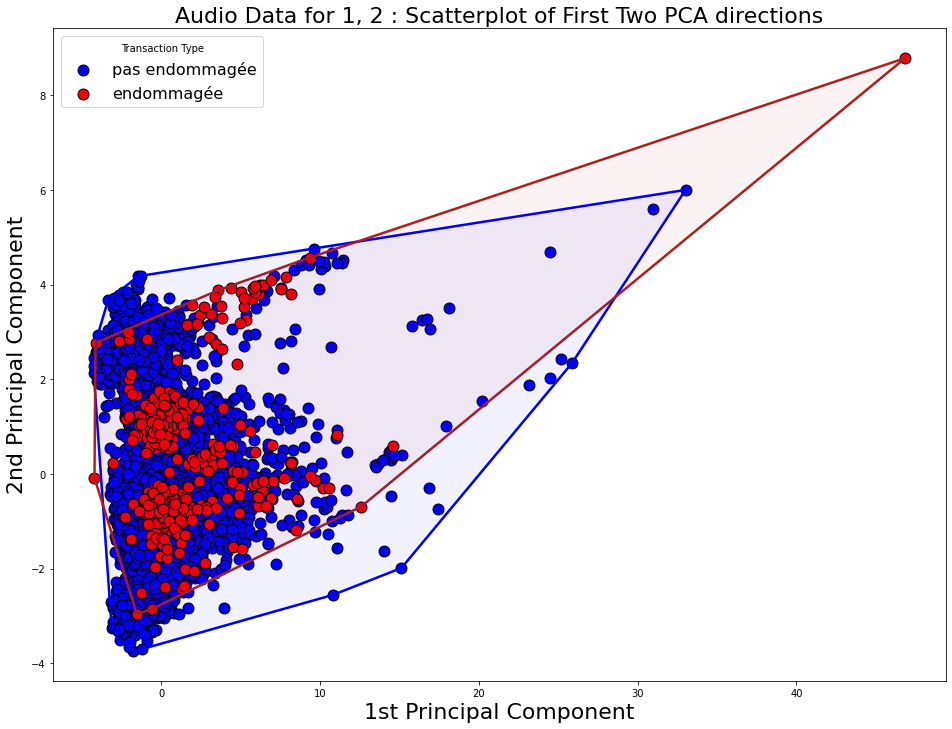

In [66]:
# Scatterplot against PC1 and PC2
fig, ax = plt.subplots(1,1, figsize=(16,12))

# Row masks for each category
rows_0 = Y==0;
rows_1 = Y==1; 


# Plot
ax.scatter(df_pca.loc[rows_0.tolist(), 1], df_pca.loc[rows_0.tolist(), 2], c='blue', edgecolor='k', s=120, label='pas endommagée')
ax.scatter(df_pca.loc[rows_1.tolist(), 1], df_pca.loc[rows_1.tolist(), 2], c='red', edgecolor='k', s=120, label='endommagée')

# Encircle the boundaries
encircle(df_pca.loc[rows_0.tolist(), 1], df_pca.loc[rows_0.tolist(), 2], ec="blue", fc="none", linewidth=2.5)
encircle(df_pca.loc[rows_1.tolist(), 1], df_pca.loc[rows_1.tolist(), 2], ec="firebrick", fc="none", linewidth=2.5)

# Shading
encircle(df_pca.loc[rows_1.tolist(), 1], df_pca.loc[rows_1.tolist(), 2], ec="k", fc="firebrick", alpha=0.05)
encircle(df_pca.loc[rows_0.tolist(), 1], df_pca.loc[rows_0.tolist(), 2], ec="k", fc="blue", alpha=0.05)

# Labels
ax.set_title("Audio Data for 1, 2 : Scatterplot of First Two PCA directions", fontsize=22)
ax.set_xlabel("1st Principal Component", fontsize=22)
ax.set_ylabel("2nd Principal Component", fontsize=22)
ax.legend(loc='best', title='Transaction Type', fontsize=16)
plt.show()